In [1]:
# import display libs
from IPython.display import Image
%matplotlib inline
from IPython.display import Latex

In [2]:
# import libs
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt


# setup figure params
figureparams = {'axes.labelsize': 24,
           'axes.titlesize': 20,
           'axes.linewidth': 1.3,
           'font.size': 20,
           'legend.fontsize': 18,
           'figure.figsize': (10,7),
           'font.family': 'serif',
           'font.serif': 'Computer Modern Roman',
           'xtick.labelsize': 18,
           'xtick.major.size': 5.5,
           'xtick.major.width': 1.3,
           'ytick.labelsize': 18,
           'ytick.major.size': 5.5,
           'ytick.major.width': 1.3,
           'text.usetex': True,
           'figure.autolayout': True}
plt.rcParams.update(figureparams)
matplotlib.rcParams['text.usetex']=False
matplotlib.rcParams['text.latex.unicode']=True
matplotlib.get_configdir()

C:\Users\EdwardJansenADC\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.


'C:\\Users\\EdwardJansenADC\\.matplotlib'

# Bivariate Analysis

In general, there are two kinds of bivariate analysis one can do: one can anaylse the variation of all isolated explanatory variables against the target variable and one can analyse the variation of the explanatory variables against each other. 

The first type of analysis is mainly done to identify strong explanatory variables and create insight in the data. This is basically the same type of analysis (although more rigorous) as the boxplots created in the notebook 'data_exploration.ipynb'. There are many methods one can use to perform the analysis. In this notebook, we will look at two of them: the 'Weight of Evidence and Information Value' analysis and univariate regression.

The second type of analysis is mainly done to identify explanatory variables that are highly correlated, as well as gaining insights into the data. Most classifiers (and all regressions ?) assume that the explanatory variables are uncorrelated. As such, we want to detect correlated pairs (or even clusters!) of variables and use only one of them in our model. In practice, determining which variables are correlated can be tricky. For numerical variables, it is customary to look at whether the (linear) correlation coefficient of the variables exceeds a certain (arbitrary) threshold. For ordinal variables, one can used a ranked correlation measure to perform the same test. For nominal variables, I have no clue .... 

### Load Data

As always, we start by loading data and extracting the numerical variables and categorical variables for further treatment. 

In [3]:
df = pd.read_csv('data/randomisedData.csv')
cols = df.columns
numvars = cols[df.dtypes != 'object']
cats = cols[df.dtypes == 'object']

In [4]:
cats

Index(['period', 'region', 'housing', 'gender'], dtype='object')

In [8]:
df.region.unique()

array(['Flevoland', 'Noord-Holland', 'Limburg', 'Gelderland',
       'Zuid-Holland', 'Noord-Brabant', 'Overijssel', 'Friesland',
       'Groningen', 'Zeeland', 'Utrecht', 'Drenthe', 'unspecified'],
      dtype=object)

### Create Ordinal Variables

Next, we create ordinal variables from the categorical variables. At some point, we will have to decide whether to incorporate the categorical variables as ordinal (i.e. ordered) variables or nominal variables. In general, one can infer the right kind of approach per variables based on what the variables encodes. Variables that can be ordered should be encoded with a simple number. Variables that can't be ordered should be considered nominal variables and can be encoded as dummy variables. An example will clarify a lot:

Ordinal: variable 'Height', with values ['Shortest', 'Short', 'Tall', 'Tallest'] is clearly orderable. As such, a proper encoding would be [0, 1, 2, 3].

Nominal: variable 'Color' with values ['Red', 'Green', 'Blue'] is clearly not orderable. (Unless you're a color fascist and think that red is the color to rule them all.) In this case, one would create three new binary variables 'ind_Red', 'ind_Green', 'ind_Blue', that would represent the color. E.g. the original 'Red' would be represented by 'ind_Red': 1, 'ind_Green': 0, 'ind_Blue': 0. As one can see, this approach becomes quite cumbersome if one has a lot of nominal variables that have a lot of unique values.

For now, we encode all categorical variables as ordinal variables. 

In [6]:
from sklearn.preprocessing import LabelEncoder
LE = LabelEncoder()

for i in cats[1::]:
    df[i] = LE.fit_transform(df[i])

### Correlation Analysis

Correlation Shmorrelation

Correlation is tricky subject. The reason for this is that using the formula for computing a coefficient between two variables, one will always find a number, but it might be a bit unclear what exactly that number tells you. For Pearson's coefficient (the linear one), one can compute a p-value to assess the significance of the coefficient, but that only holds under certain specific assumptions (normality and other non-realistic things..). 

Another problems is that most relationships between variables will not be linear. In this case, one can resort to e.g. Spearman's coefficient, which psychologists call a nonlinear measure of correlation. Although Spearman's coefficient (and Kendall's $\tau$ for that matter) can capture nonlinear relationships to some extent, it really is just a rank-based coefficient. That is, it does not look at the magnitude of a value, but at its rank compared to the other values. As such, these rank coefficients should be quite suitable to use assess the correlation between ordinal variables, which are - after all - rank-based variables.

Then there's one category left: nominal variables. I'm no expert on this, but seem to have seen somewhere that one can use the method of contingency tables (combined with $\chi^2$) here. [TODO: Expand!]

So, let's be practical about this. A good way to assess correlation between variables is the following (check!):
- divide the data into numerical variables, ordinal variables and nominal variables;
- compute the correlation matrix for all three subgroups in the appropriate manner; in practice, this will probably mean computing several versions of the correlation matrix and interpreting the result. The single one thing that is forbidden: using Pearson that compute the correlation between ordinal or nominal variables.
- try to compute the correlation matrix for all variables combined; I think this will fail for nominal variables (true?), but ordinal and numerical variables should be comparable with a rank-based measure.

TODO: currently, we have been sloppy and coded the nominal vars as ordinal vars as well. Update! and fix the contingency tables!

https://medium.com/@outside2SDs/an-overview-of-correlation-measures-between-categorical-and-continuous-variables-4c7f85610365

#### numvars

C:\Users\EdwardJansenADC\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


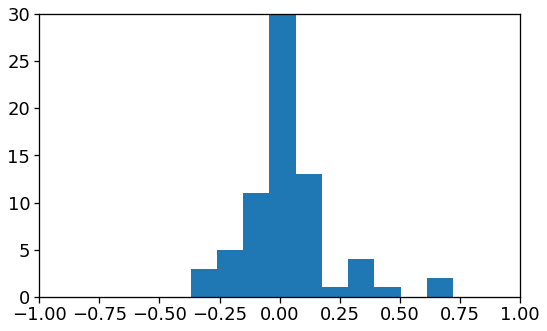

In [7]:
def correlation_check(df, threshold, bins=10, method='pearson', figsave=False):
    """
    Function that plots the distribution of correlation coefficients between the independent variables and 
    finds the coefficients (and their indices) that are bigger than a certain threshold.  
    ---------
    Input:
        df          dataframe; dataframe with (WoE values of) independent variables 
        threshold   scalar; maximal allowed correlation between 'independent' variables
    
    Returns:
        corr plot   plot; plot of distribution of correlation coefficients
        [c., x, y]  tuple; tuple containing the larger than threshold coefficients with corresponding x,y
                           indices in the correlation matrix.
    
    """
    # compute correlation matrix, extract upper triangle, find coefficients and corresponding variables
    corr = np.triu(df.corr(method=method),1)
    idx,idy = np.where(corr>threshold)
    corrcoef = corr[idx, idy]
    x = df.columns[idx]
    y = df.columns[idy]

    # plot distribution of corr coefficients
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize=(8,5))
    ax.hist(corr.flatten(), bins=bins, normed=False)
    ax.set_xlim([-1,1])
    ax.set_ylim([0,30])

    if figsave == True:
        plt.savefig(r'figs/corrcoef_hist.pdf')
        
    return [corrcoef, x, y]

corr_test_df = correlation_check(df[numvars], threshold=0.6, method='pearson')

In [8]:
corr_test_df

[array([0.7214256 , 0.66538636]),
 Index(['arrears.amount', 'loan.amount'], dtype='object'),
 Index(['arrears.at.default', 'market.value'], dtype='object')]

#### cats

NOTE TO SELF: this is a bit weird. None of our categorical variables are really ordinal, so using Spearman is somewhat pointless here.

C:\Users\EdwardJansenADC\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


[array([], dtype=float64),
 Index([], dtype='object'),
 Index([], dtype='object')]

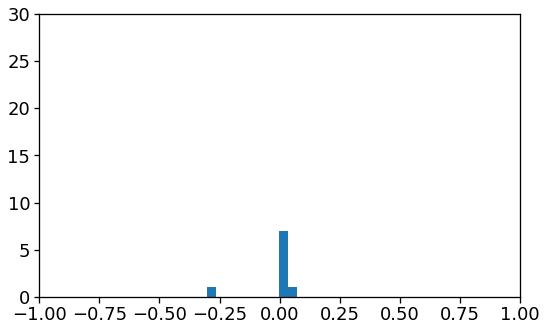

In [11]:
corr_test_df = correlation_check(df[cats], threshold=0.6, method='spearman')
corr_test_df

#### Contingency tables

In [19]:
def cramers_corrected_stat(x,y):
    
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    import scipy.stats as ss
    result=-1
    if len(x.value_counts())==1 :
        print("First variable is constant")
    elif len(y.value_counts())==1:
        print("Second variable is constant")
    else:   
        conf_matrix=pd.crosstab(x, y)

        if conf_matrix.shape[0]==2:
            correct=False
        else:
            correct=True

        chi2 = ss.chi2_contingency(conf_matrix, correction=correct)[0]

        n = sum(conf_matrix.sum())
        phi2 = chi2/n
        r,k = conf_matrix.shape
        phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
        rcorr = r - ((r-1)**2)/(n-1)
        kcorr = k - ((k-1)**2)/(n-1)
        result=np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))
    return round(result,6)

corr_cats = np.zeros((len(cats), len(cats)))
for i in range(len(cats)):
    for j in range(i, len(cats)):
        corr_cats[i,j] = cramers_corrected_stat(df[cats[i]], df[cats[j]])

corr_cats

array([[1.      , 0.      , 0.079656, 0.603215],
       [0.      , 1.      , 0.138969, 0.081745],
       [0.      , 0.      , 1.      , 0.189213],
       [0.      , 0.      , 0.      , 1.      ]])

C:\Users\EdwardJansenADC\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


[array([], dtype=float64),
 Index([], dtype='object'),
 Index([], dtype='object')]

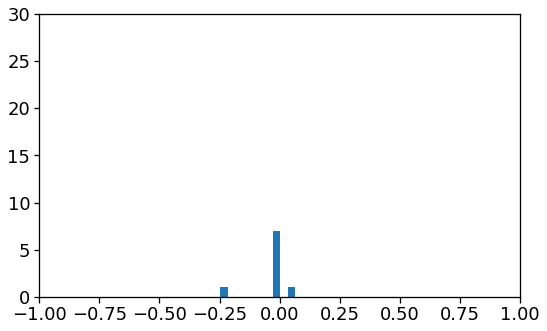

In [12]:
corr_test_df = correlation_check(df[cats], threshold=0.6, method='kendall')
corr_test_df

#### Both

C:\Users\EdwardJansenADC\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


Spearman:
     [0.78140426 0.63949617]
     Index(['period', 'arrears.amount'], dtype='object')
     Index(['no.months.default', 'ltv'], dtype='object')
Kendall's $	au$:
     [0.65235373]
     Index(['period'], dtype='object')
     Index(['no.months.default'], dtype='object')
Pearson (which shouldnn't make to much sense:
     [0.7214256  0.66538636]
     Index(['period', 'arrears.amount'], dtype='object')
     Index(['no.months.default', 'ltv'], dtype='object')


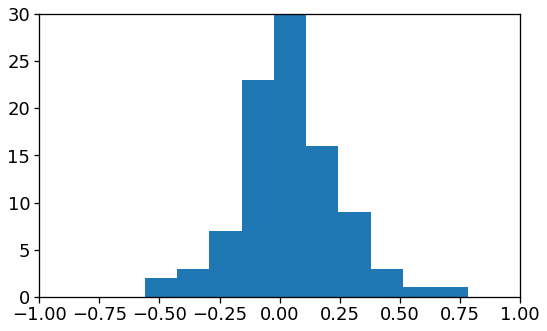

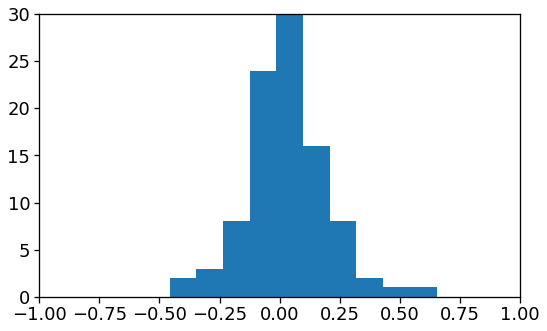

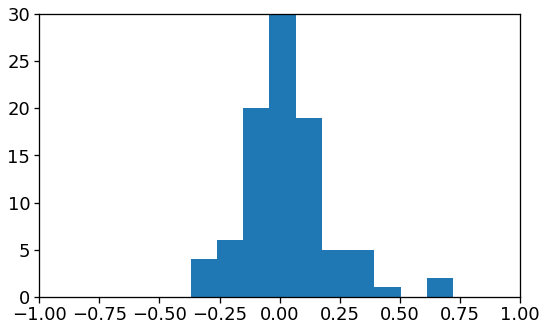

In [18]:
corr_test_df = correlation_check(df, threshold=0.6, method='spearman')
print("Spearman:")
for i in range(3):
    print("     " + str(corr_test_df[i]))
corr_test_df = correlation_check(df, threshold=0.6, method='kendall')
print("Kendall's $\tau$:")
for i in range(3):
    print("     " + str(corr_test_df[i]))
corr_test_df = correlation_check(df, threshold=0.6, method='pearson')
print("Pearson (which shouldn't make to much sense):")
for i in range(3):
    print("     " + str(corr_test_df[i]))

In [17]:
corr_test_df[2]

Index(['no.months.default', 'ltv'], dtype='object')

### Weight of Evidence

In [88]:
def binning(df, target, exception, bins=10, labels=None):
    """
    Function binnes a Pandas dataframe using .qcut(), which tries to make bins of equal frequency.
    ---------
    Input:
        df:         dataframe;
        target:     string; name of dependent variable
        bins:       list; number of ideal bins
    
    Returns:
        binned_df   dataframe; the binned dataframe
        retbins     list; list of bins per variable
        lbl         list; list of variables the algorithm does not bin
    
    """
    data = df.copy(deep=True)
    cols_ = data.columns[~data.columns.isin([target])] 
    cols = cols_[~cols_.isin(exception)]
    binned_df = pd.DataFrame(columns = cols)
    retbins = []
    lbl = []
    
    # bin if number of unique vals / per > 10, otherwise do nothing
    for i in cols[~cols.isin([target])]:
        if (len(np.unique(data[i]))>15):
            binned_df[i], tmp = pd.qcut(data[i], bins, retbins=True, duplicates='drop', labels=labels)
            retbins.append(tmp)
        else:
            binned_df[i] = data[i]
            tmp = len(binned_df[i].unique())
            retbins.append(tmp)
            lbl.append(i)
            
        binned_df[target] = data[target]
        
    return binned_df, retbins, lbl

binned_df, _, _ = binning(df, 'target', ['ID', 'period'], bins=10)

In [80]:
binned_df

,arrears.amount,loan.amount,no.months.default,arrears.at.default,ltv,market.value,interest,region,housing,maturity.remaining,gender,cust.age,years.as.customer,target
0,"(700.61, 1117.518]","(151.41899999999998, 90111.21]","(8.0, 10.0]","(777.247, 1198.623]","(-0.000648, 0.444]","(185249.342, 208489.498]","(4.9, 5.158]",1,9,"(-0.001, 173.0]",2,"(65.0, 120.0]","(10.0, 13.0]",1
1,"(700.61, 1117.518]","(151.41899999999998, 90111.21]","(10.0, 13.5]","(777.247, 1198.623]","(-0.000648, 0.444]","(161355.144, 185249.342]","(4.9, 5.158]",1,9,"(-0.001, 173.0]",2,"(65.0, 120.0]","(10.0, 13.0]",1
2,"(700.61, 1117.518]","(151.41899999999998, 90111.21]","(13.5, 18.0]","(777.247, 1198.623]","(-0.000648, 0.444]","(161355.144, 185249.342]","(4.9, 5.158]",1,9,"(-0.001, 173.0]",2,"(65.0, 120.0]","(10.0, 13.0]",1
3,"(700.61, 1117.518]","(151.41899999999998, 90111.21]","(13.5, 18.0]","(777.247, 1198.623]","(-0.000648, 0.444]","(161355.144, 185249.342]","(4.9, 5.158]",1,9,"(-0.001, 173.0]",2,"(65.0, 120.0]","(10.0, 13.0]",1
4,"(700.61, 1117.518]","(151.41899999999998, 90111.21]","(2.0, 3.0]","(777.247, 1198.623]","(-0.000648, 0.444]","(208489.498, 239045.874]","(5.158, 5.45]",7,9,"(317.0, 800.0]",2,"(65.0, 120.0]","(18.0, 35.0]",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7861,"(14031.645, 253017.391]","(282412.143, 357990.454]","(4.0, 6.0]","(10193.25, 105037.753]","(0.622, 0.737]","(348643.081, 466997.372]","(6.05, 11.451]",8,8,"(-0.001, 173.0]",2,"(44.0, 48.0]","(10.0, 13.0]",1
7862,"(0.669, 347.765]","(119039.509, 143694.324]","(0.999, 2.0]","(1.5650000000000002, 394.603]","(0.622, 0.737]","(161355.144, 185249.342]","(5.7, 6.05]",9,3,"(-0.001, 173.0]",2,"(31.0, 37.0]","(5.0, 7.0]",1
7863,"(14031.645, 253017.391]","(357990.454, 1118674.939]","(10.0, 13.5]","(10193.25, 105037.753]","(0.892, 0.971]","(466997.372, 2700748.71]","(3.19, 3.8]",2,7,"(263.0, 277.0]",2,"(48.0, 51.0]","(-0.001, 2.0]",1
7864,"(14031.645, 253017.391]","(357990.454, 1118674.939]","(13.5, 18.0]","(10193.25, 105037.753]","(0.892, 0.971]","(466997.372, 2700748.71]","(-0.301, 3.19]",2,7,"(263.0, 277.0]",2,"(48.0, 51.0]","(-0.001, 2.0]",1


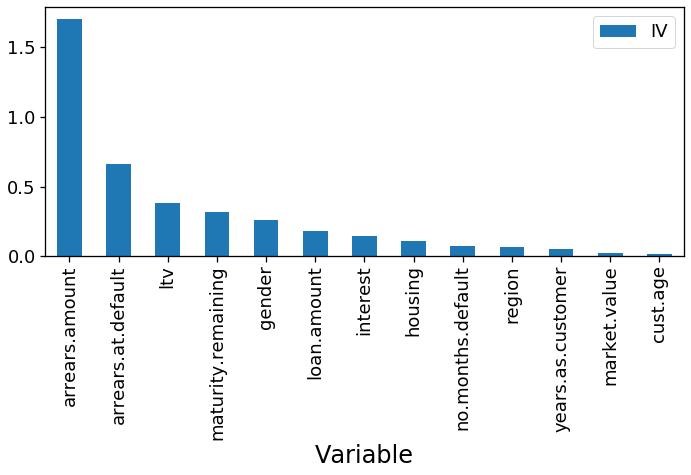

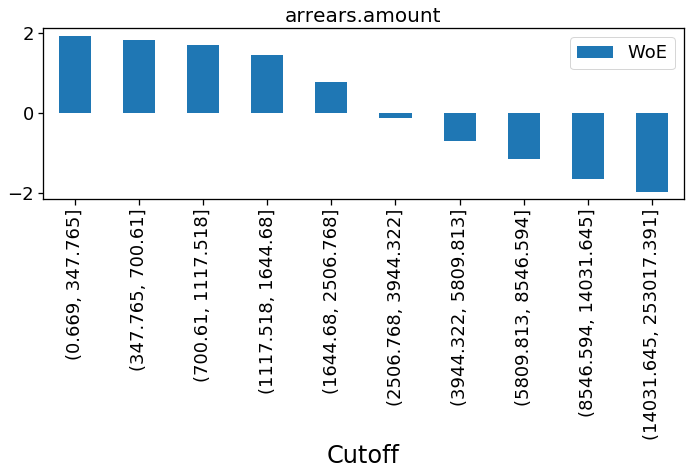

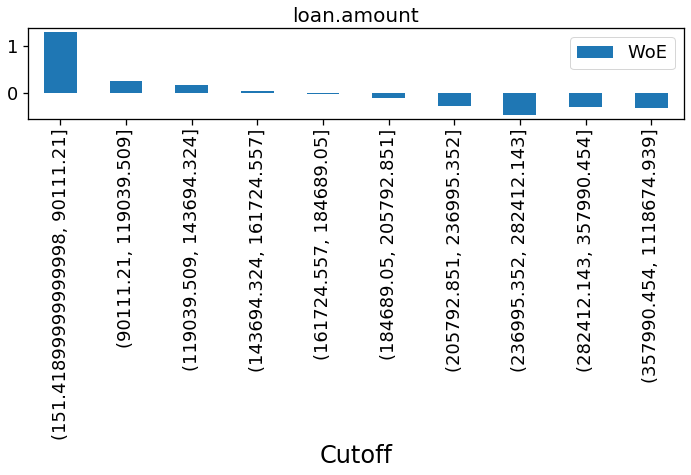

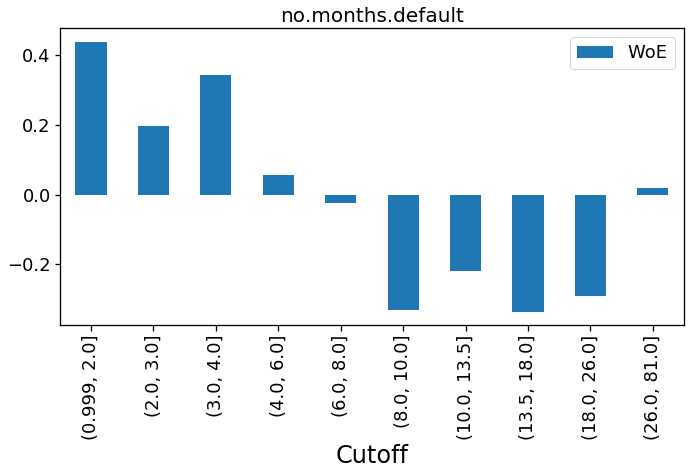

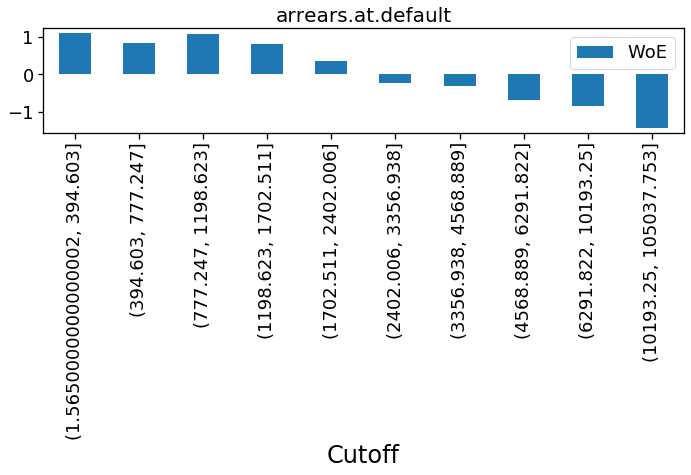

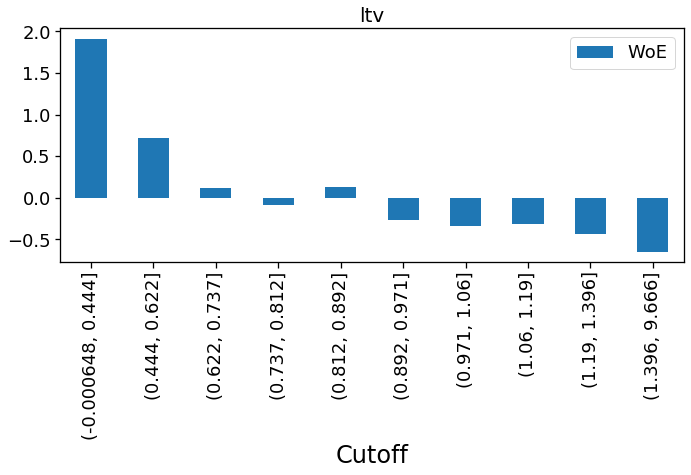

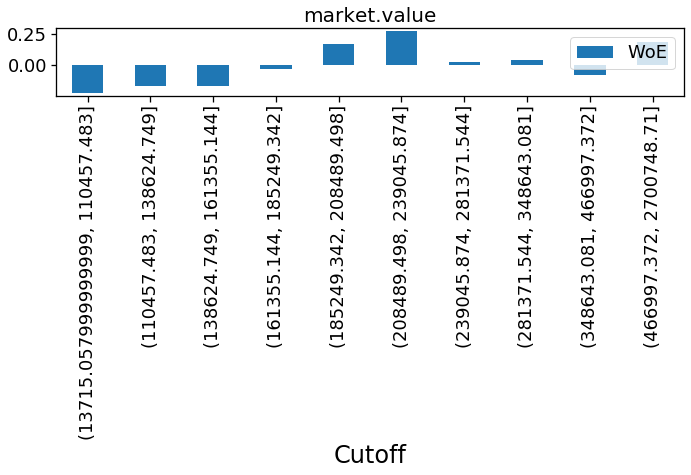

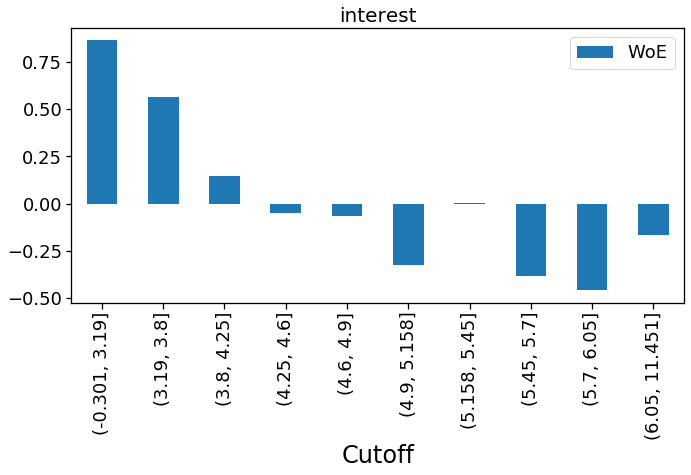

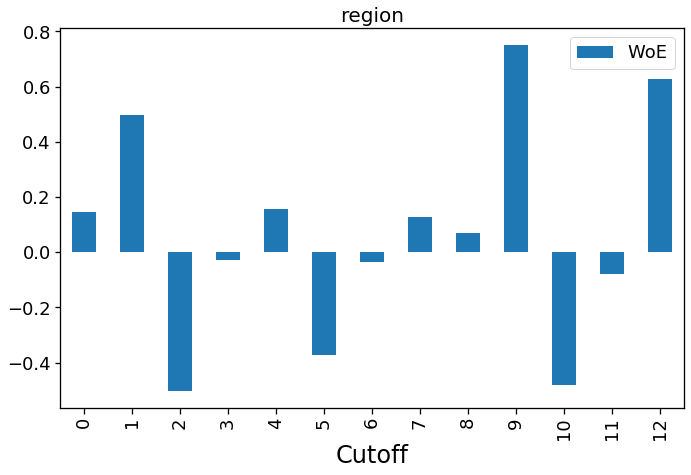

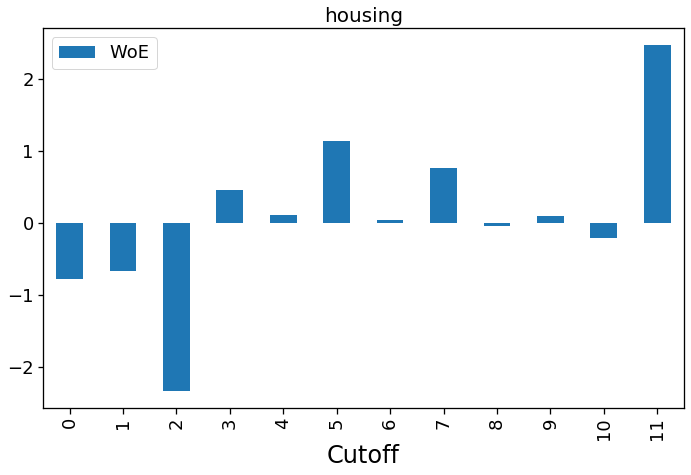

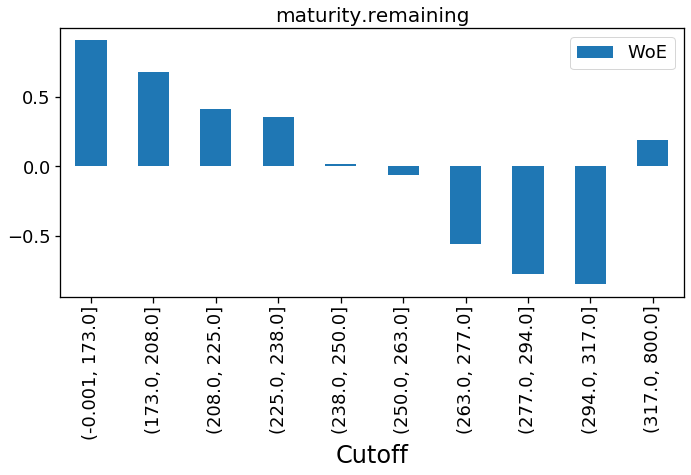

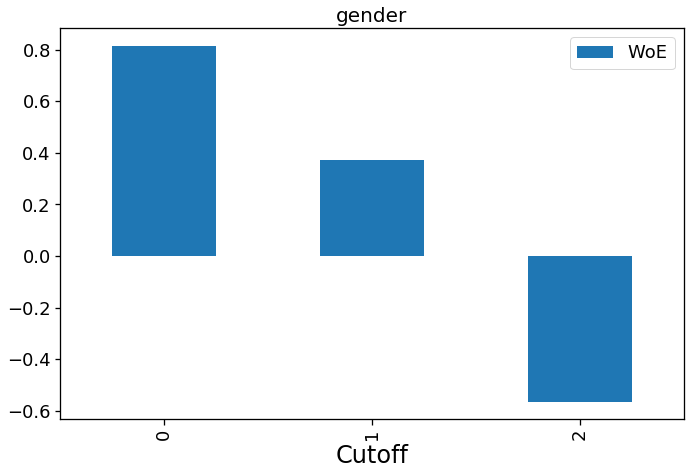

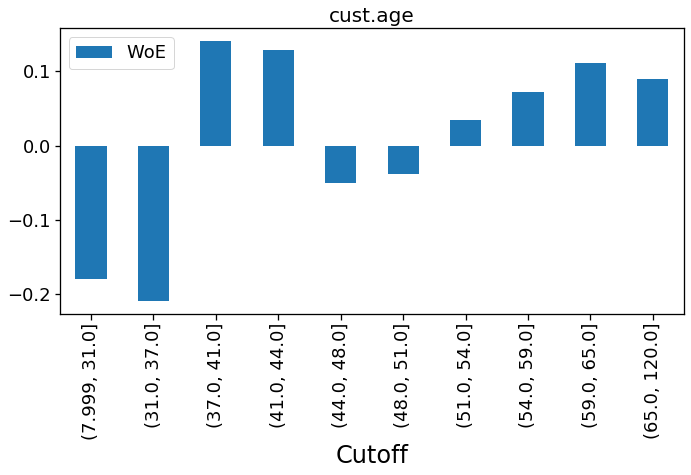

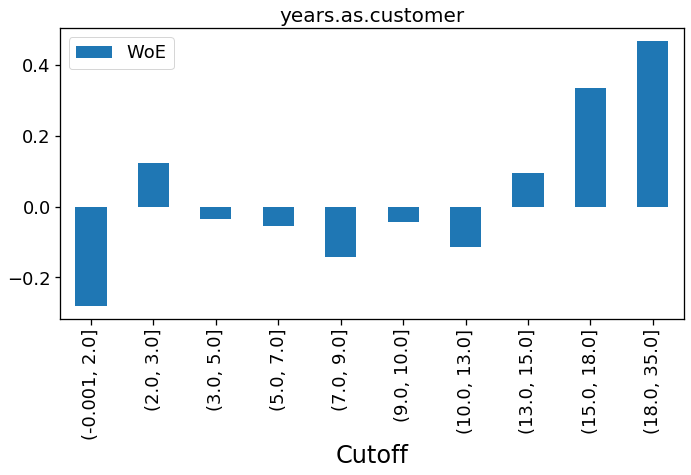

In [81]:
## Weight of Evidence

def test_woe(df, target, trend_visualize=True):
    """
    Function computes WoE en IV values for all variables in the input dataframe that should already be binned.  
    ---------
    Input:
        df:         dataframe; dataframe containing the binned variables
        target:     string; name of dependent variable
    
    Returns:
        IV plot     plot; plots IV values per variable
        WoE plot    plot; plots WoE per bin for every variable
        cols        pd index; array with column names
        d_lst       list; list containing bin statistics including WoE & IV
        df_IV       dataframe; df containing IV per variable
    """
    data = df.copy(deep=True)
    cols = data.columns[~data.columns.isin([target])] 
    d_lst = []
    df_IV = pd.DataFrame()
   
    # Compute WoE and IV per category for each variable 
    for i in cols:
        df0 = pd.DataFrame({'x': data[i], 'y': data[target]})
        
        d = df0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']
        d['% of Events'] = (d['Events']+0.5) / d['Events'].sum()  #prevent /0
        d['Non-Events'] = d['N'] - d['Events']
        d['% of Non-Events'] = (d['Non-Events']+0.5)/ d['Non-Events'].sum() #prevent /0
        d['WoE'] = np.log(d['% of Events']/d['% of Non-Events'])

        d['IV'] = d['WoE'] * (d['% of Events'] - d['% of Non-Events']) 
        d_lst.append(d)
        temp = pd.DataFrame({"Variable" : [i], "IV" : [d['IV'].sum()]}, columns = ["Variable", "IV"])
        df_IV = pd.concat([df_IV,temp], axis=0) 
    
    # create table with sorted IV per variable
    df_IV = df_IV.sort_values('IV', axis=0, ascending=False)   
    df_IV.plot.bar(x='Variable', y = 'IV')
    
    # show plots of WoE per category for each variable    
    if trend_visualize == True:
        for i in range(len(cols)):
            ax = d_lst[i].plot.bar(x='Cutoff', y='WoE')
            ax.set_title(cols[i]) 
   
    return cols, d_lst, df_IV

cols, d_lst, df_IV = test_woe(binned_df, 'target', trend_visualize=True)

In [82]:
## replace WoE

def replace_woe(df, d_lst, target):
    """
    Function replaces bin values with WoE values.  
    ---------
    Input:
        df:         dataframe; dataframe containing the binned variables
        d_lst:      list; list with the bin statistics of which the WoE value is used
        target:     string; name of dependent variable
    
    Returns:
        woe_df      dataframe; dataframe containing the df with WoE values for all variables
    
    """
    data = df.copy(deep=True)    
    cols = data.columns[~data.columns.isin([target])] 
    woe_df = pd.DataFrame()

    # for each variable i, replace the bin values in data with the WoE values in d_lst
    k=0
    for i in cols:
        for j in range(len(d_lst[k])):
            data.loc[  data[i].eq(d_lst[k]['Cutoff'][j]), 'woe_'+str(i)  ] = d_lst[k]['WoE'][j]
        k+=1
    woe_cols = ['woe_'+str(cols[i]) for i in range(len(cols))]
    woe_df = data[woe_cols]
    woe_df = pd.concat([woe_df, data[target]], axis=1)
    
    return woe_df

woe_df = replace_woe(binned_df, d_lst, 'target')

In [83]:
woe_df

,woe_arrears.amount,woe_loan.amount,woe_no.months.default,woe_arrears.at.default,woe_ltv,woe_market.value,woe_interest,woe_region,woe_housing,woe_maturity.remaining,woe_gender,woe_cust.age,woe_years.as.customer,target
0,1.697946,1.280338,-0.331929,1.070964,1.912846,0.169891,-0.322865,0.495721,0.097959,0.906352,-0.564176,0.090185,-0.114724,1
1,1.697946,1.280338,-0.219314,1.070964,1.912846,-0.030263,-0.322865,0.495721,0.097959,0.906352,-0.564176,0.090185,-0.114724,1
2,1.697946,1.280338,-0.336353,1.070964,1.912846,-0.030263,-0.322865,0.495721,0.097959,0.906352,-0.564176,0.090185,-0.114724,1
3,1.697946,1.280338,-0.336353,1.070964,1.912846,-0.030263,-0.322865,0.495721,0.097959,0.906352,-0.564176,0.090185,-0.114724,1
4,1.697946,1.280338,0.198299,1.070964,1.912846,0.274683,0.003982,0.126262,0.097959,0.185989,-0.564176,0.090185,0.466192,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7861,-1.964927,-0.280351,0.057533,-1.422209,0.114131,-0.080094,-0.167787,0.069283,-0.039151,0.906352,-0.564176,-0.050800,-0.114724,1
7862,1.929383,0.166423,0.439486,1.100555,0.114131,-0.030263,-0.457279,0.749702,0.463929,0.906352,-0.564176,-0.209016,-0.055911,1
7863,-1.964927,-0.300386,-0.219314,-1.422209,-0.264972,0.183087,0.564807,-0.501938,0.765478,-0.561089,-0.564176,-0.037963,-0.281043,1
7864,-1.964927,-0.300386,-0.336353,-1.422209,-0.264972,0.183087,0.862756,-0.501938,0.765478,-0.561089,-0.564176,-0.037963,-0.281043,1


### Univariate Regression